# Triplet Attention GradCAM Results

Note: in this notebook, we refer to Triplet Attention as "PCAM" or "pcam" in the variable names, comments, etc. This was an internal working name for this project, and is the same thing as triplet attention. We do not use this name anymore officially. 

In [ ]:
from MODELS.resnet import *

To generate GradCAM results for CBAM, you need to have the CBAM module in `MODELS` directory

In [6]:
cbam_model = ResidualNet("ImageNet", 50, 1000, "CBAM")
pcam_model = ResidualNet("ImageNet", 50, 1000, "PCAM")

cbam_model_state_dict = dict()
pcam_model_state_dict = dict()
cbam_state_dict = torch.load("RESNET50_CBAM_new_name_wrap.pth")["state_dict"]
pcam_state_dict = torch.load("RESNET50_PCAM_IMAGENET_model_best.pth.tar")["state_dict"]

for key in cbam_state_dict:
    cbam_model_state_dict[key[7:]] = cbam_state_dict[key]
for key in pcam_state_dict:
    pcam_model_state_dict[key[7:]] = pcam_state_dict[key]

cbam_model.load_state_dict(cbam_model_state_dict)
pcam_model.load_state_dict(pcam_model_state_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


<All keys matched successfully>


# GradCAM

In [ ]:
%%capture
!pip install fastai2

In [ ]:
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from fastai2.vision.all import *


class FeatureExtractor:
    """Class for extracting activations and
    registering gradients from targetted intermediate layers"""

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs:
    """Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers."""

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0), -1)
            else:
                x = module(x)

        return target_activations, x


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    plt.imshow(np.uint8(255 * cam))
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))


def get_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return PILImage.create(np.uint8(255 * cam))


class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(
            self.model, self.feature_module, target_layer_names
        )

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--use-cuda",
        action="store_true",
        default=False,
        help="Use NVIDIA GPU acceleration",
    )
    parser.add_argument(
        "--image-path", type=str, default="./examples/both.png", help="Input image path"
    )
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args


def deprocess_image(img):
    """see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65"""
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)

In [ ]:
""" python grad_cam.py <path_to_image>
1. Loads an image with opencv.
2. Preprocesses it for VGG19 and converts to a pytorch variable.
3. Makes a forward pass to find the category index with the highest score,
and computes intermediate activations.
Makes the visualization. """


# image_path = "/content/dog.jpg"

# Can work with any model, but it assumes that the model has a
# feature method, and a classifier method,
# as in the VGG models in torchvision.
# model = models.resnet50(pretrained=True)
grad_cam = GradCam(
    model=pcam_model,
    feature_module=model.layer4,
    target_layer_names=["2"],
    use_cuda=False,
)

img = cv2.imread(image_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask = grad_cam(input, target_index)

result = get_cam_on_image(img, mask)
result.show()

# gb_model = GuidedBackpropReLUModel(model=model, use_cuda=args.use_cuda)
# print(model._modules.items())
# gb = gb_model(input, index=target_index)
# gb = gb.transpose((1, 2, 0))
# cam_mask = cv2.merge([mask, mask, mask])
# cam_gb = deprocess_image(cam_mask*gb)
# gb = deprocess_image(gb)

# cv2.imwrite('gb.jpg', gb)
# cv2.imwrite('cam_gb.jpg', cam_gb)

In [ ]:
def compare_gradcam(images, models, targets=None, use_cuda=False):
    _, axs = plt.subplots(
        len(images), len(models), figsize=(5 * len(models), 5 * len(images))
    )
    for i, image_path in enumerate(images):
        for m, model in enumerate(models):
            # inp = get_x(idx)
            # conf = PILImage.create(learn.predict(inp)[2][0].numpy())
            # pred = learn.predict(inp)[0]
            # real = get_y(idx)

            grad_cam = GradCam(
                model=model,
                feature_module=model.layer4,
                target_layer_names=["2"],
                use_cuda=use_cuda,
            )

            img = cv2.imread(image_path, 1)
            img = np.float32(cv2.resize(img, (224, 224))) / 255
            input = preprocess_image(img)

            # If None, returns the map for the highest scoring category.
            # Otherwise, targets the requested index.
            target_index = targets[i] if targets is not None else None
            mask = grad_cam(input, target_index)

            result = get_cam_on_image(img, mask)
            result.show(ctx=axs[i, m], title=f"model {m} on image {i}")

In [17]:
resnet = models.resnet50(pretrained=True)

# GradCAM ++

In [7]:
!git clone https://github.com/1Konny/gradcam_plus_plus-pytorch.git

Cloning into 'gradcam_plus_plus-pytorch'...
remote: Enumerating objects: 79, done.
remote: Total 79 (delta 0), reused 0 (delta 0), pack-reused 79
Unpacking objects: 100% (79/79), done.


In [8]:
import sys

sys.path.append("/content/gradcam_plus_plus-pytorch")

In [9]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

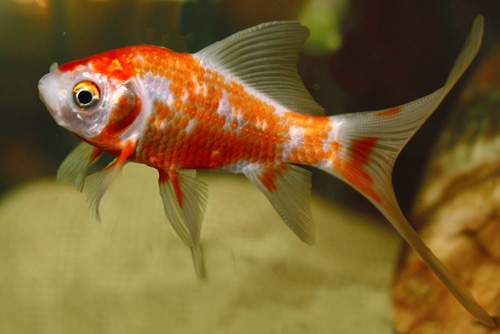

In [10]:
img_dir = "/content/"
img_name = "n01443537_5048_goldfish.jpg"
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

In [14]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = (
    torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255)
)
torch_img = F.upsample(torch_img, size=(224, 224), mode="bilinear", align_corners=False)
normed_torch_img = normalizer(torch_img)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [22]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval(), alexnet.cuda()

# vgg = models.vgg16(pretrained=True)
# vgg.eval(), vgg.cuda();

resnet = models.resnet50(pretrained=True)
resnet.eval(), resnet.cuda()

# densenet = models.densenet161(pretrained=True)
# densenet.eval(), densenet.cuda();

# squeezenet = models.squeezenet1_1(pretrained=True)
# squeezenet.eval(), squeezenet.cuda();

cbam_model.eval(), cbam_model.cuda()
pcam_model.eval(), pcam_model.cuda()


cam_dict = dict()


# alexet_model_dict = dict(type='alexnet', arch=alexnet, layer_name='features_11', input_size=(224, 224))
# alexnet_gradcam = GradCAM(alexnet_model_dict, True)
# alexnet_gradcampp = GradCAMpp(alexnet_model_dict, True)
# cam_dict['alexnet'] = [alexnet_gradcam, alexnet_gradcampp]

# vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
# vgg_gradcam = GradCAM(vgg_model_dict, True)
# vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
# cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

resnet_model_dict = dict(
    type="resnet", arch=resnet, layer_name="layer4", input_size=(224, 224)
)
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict["resnet"] = [resnet_gradcam, resnet_gradcampp]

# densenet_model_dict = dict(type='densenet', arch=densenet, layer_name='features_norm5', input_size=(224, 224))
# densenet_gradcam = GradCAM(densenet_model_dict, True)
# densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
# cam_dict['densenet'] = [densenet_gradcam, densenet_gradcampp]

# squeezenet_model_dict = dict(type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation', input_size=(224, 224))
# squeezenet_gradcam = GradCAM(squeezenet_model_dict, True)
# squeezenet_gradcampp = GradCAMpp(squeezenet_model_dict, True)
# cam_dict['squeezenet'] = [squeezenet_gradcam, squeezenet_gradcampp]

cbam_resnet_model_dict = dict(
    type="resnet", arch=cbam_model, layer_name="layer4", input_size=(224, 224)
)
cbam_resnet_gradcam = GradCAM(cbam_resnet_model_dict, True)
cbam_resnet_gradcampp = GradCAMpp(cbam_resnet_model_dict, True)
cam_dict["cbam_resnet"] = [cbam_resnet_gradcam, cbam_resnet_gradcampp]

pcam_resnet_model_dict = dict(
    type="resnet", arch=pcam_model, layer_name="layer4", input_size=(224, 224)
)
pcam_resnet_gradcam = GradCAM(pcam_resnet_model_dict, True)
pcam_resnet_gradcampp = GradCAMpp(pcam_resnet_model_dict, True)
cam_dict["pcam_resnet"] = [pcam_resnet_gradcam, pcam_resnet_gradcampp]

# resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
# resnet_gradcam = GradCAM(resnet_model_dict, True)
# resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
# cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [26]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img.cuda())
    heatmap, result = visualize_cam(mask.cpu(), torch_img.cpu())

    mask_pp, _ = gradcam_pp(normed_torch_img.cuda())
    heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), torch_img.cpu())

    # images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    images.append(torch.stack([torch_img.squeeze().cpu(), result, result_pp], 0))

images = make_grid(torch.cat(images, 0), nrow=3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


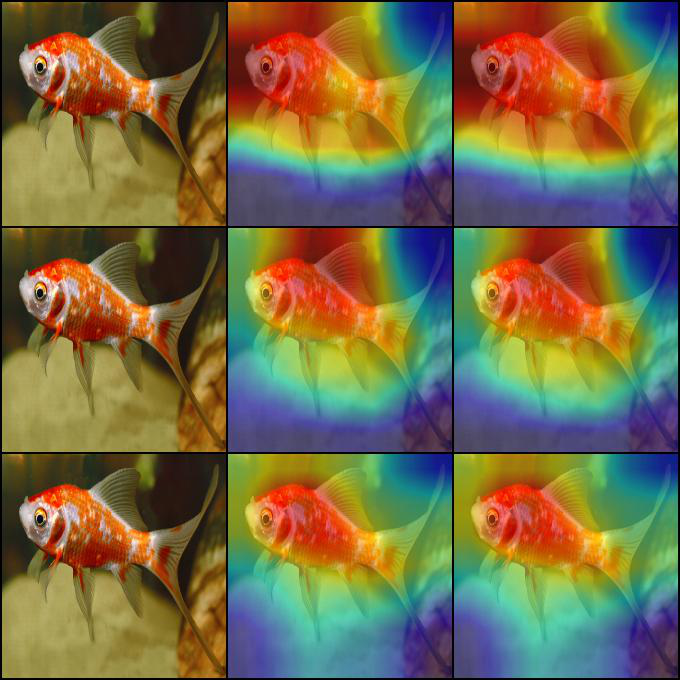

In [27]:
output_dir = "/content/outputs"
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)